# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `***`
- **База данных** — `***`
- **Порт** — `***`
- **Аутентификация** — `***`
- **Пользователь** — `***`
- **Пароль** — `***`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [70]:
!pip install pandas
!pip install sqlalchemy
!pip install psycopg2-binary
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install phik
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [71]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import os
from dotenv import load_dotenv

In [72]:
load_dotenv()

user = os.getenv('USER') # имя пользователя
pwd = os.getenv('PASSWORD') # пароль
host = os.getenv('HOST')
port = os.getenv('PORT') # порт подключения
db = os.getenv('DB') # название базы данных

db_config = {'user': user,
             'pwd': pwd,
             'host': host,
             'port': port,
             'db': db
             }

In [73]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [74]:
engine = create_engine(connection_string)

In [75]:
query = '''
SELECT *
FROM afisha.purchases p
'''
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [76]:
# 1. Основные характеристики
print("1. Объем и структура данных")
print(f"Количество строк (заказов): {df.shape[0]}")
print(f"Количество столбцов (характеристик): {df.shape[1]}")
print("\nСписок столбцов:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")

1. Объем и структура данных
Количество строк (заказов): 292034
Количество столбцов (характеристик): 13

Список столбцов:
 1. order_id
 2. user_id
 3. created_dt_msk
 4. created_ts_msk
 5. event_id
 6. cinema_circuit
 7. age_limit
 8. currency_code
 9. device_type_canonical
10. revenue
11. service_name
12. tickets_count
13. total


In [77]:
# 2. Типы данных
print("\n2. Типы данных")
print(df.dtypes)


2. Типы данных
order_id                          int64
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int64
cinema_circuit                   object
age_limit                         int64
currency_code                    object
device_type_canonical            object
revenue                         float64
service_name                     object
tickets_count                     int64
total                           float64
dtype: object


In [78]:
# 3. Пропущенные значения
print("\n3. Пропущенные значения")
print(df.isnull().sum())


3. Пропущенные значения
order_id                 0
user_id                  0
created_dt_msk           0
created_ts_msk           0
event_id                 0
cinema_circuit           0
age_limit                0
currency_code            0
device_type_canonical    0
revenue                  0
service_name             0
tickets_count            0
total                    0
dtype: int64


In [79]:
# 4. Дубликаты
print(f"\n4. Дубликаты: {df.duplicated().sum()}")


4. Дубликаты: 0


In [80]:
# 5. Статистика числовых полей
print("\n5. Статистика числовых полей")
print(df.describe())


5. Статистика числовых полей
           order_id                 created_dt_msk  \
count  2.920340e+05                         292034   
mean   4.326435e+06  2024-09-01 21:06:45.100775680   
min    1.000000e+00            2024-06-01 00:00:00   
25%    2.162567e+06            2024-07-30 00:00:00   
50%    4.327134e+06            2024-09-12 00:00:00   
75%    6.489179e+06            2024-10-09 00:00:00   
max    8.653108e+06            2024-10-31 00:00:00   
std    2.498049e+06                            NaN   

                      created_ts_msk       event_id      age_limit  \
count                         292034  292034.000000  292034.000000   
mean   2024-09-02 12:01:25.812874752  437938.109908      10.210195   
min              2024-06-01 00:00:42    4436.000000       0.000000   
25%       2024-07-30 11:48:37.500000  361300.000000       6.000000   
50%       2024-09-12 13:04:46.500000  498054.000000      12.000000   
75%    2024-10-09 15:36:04.249999872  546269.000000      16.000

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---

In [81]:
# Загрузка данных о курсе тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [82]:
# Конвертация выручки
df['revenue_rub'] = df['revenue']
mask_kzt = df['currency_code'] == 'KZT'
df.loc[mask_kzt, 'revenue_rub'] = df.loc[mask_kzt, 'revenue'] * (tenge_df['curs'].iloc[0] / 100)

In [83]:
print('Конвертация завершена.')
print('Первые строки:')
print(df[['currency_code', 'revenue', 'revenue_rub']].head())

Конвертация завершена.
Первые строки:
  currency_code  revenue  revenue_rub
0           rub   568.43       568.43
1           rub   575.08       575.08
2           rub   402.51       402.51
3           rub   487.94       487.94
4           rub     8.95         8.95


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [84]:
# Проверяем пропуски
print("Проверяем пропущенные значения")
missing = df.isnull().sum()
print(missing)

Проверяем пропущенные значения
order_id                 0
user_id                  0
created_dt_msk           0
created_ts_msk           0
event_id                 0
cinema_circuit           0
age_limit                0
currency_code            0
device_type_canonical    0
revenue                  0
service_name             0
tickets_count            0
total                    0
revenue_rub              0
dtype: int64


In [85]:
# Меняем типы данных

# Целые числа
df['tickets_count'] = df['tickets_count'].astype('int64')
df['age_limit'] = df['age_limit'].astype('int64')

# Категории
df['currency_code'] = df['currency_code'].astype('category')
df['device_type_canonical'] = df['device_type_canonical'].astype('category')
df['service_name'] = df['service_name'].astype('category')
df['cinema_circuit'] = df['cinema_circuit'].astype('category')

print("Проверяем типы после преобразования:")
print(df.dtypes)

Проверяем типы после преобразования:
order_id                          int64
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int64
cinema_circuit                 category
age_limit                         int64
currency_code                  category
device_type_canonical          category
revenue                         float64
service_name                   category
tickets_count                     int64
total                           float64
revenue_rub                     float64
dtype: object


In [86]:
# Проверяем категориальные поля

cat_cols = ['currency_code', 'device_type_canonical', 'service_name', 'cinema_circuit']

for col in cat_cols:
    print(f"\n{col}:")
    unique_vals = df[col].unique()
    print(f"Всего значений: {len(unique_vals)}")
    
    # Проверяем на странные значения
    strange = []
    for val in unique_vals:
        if isinstance(val, str):
            val_lower = val.lower()
            if val_lower in ['nan', 'null', 'none', 'na', '', 'unknown', 'not specified']:
                strange.append(val)
    
    if strange:
        print(f"Странные значения: {strange}")
    else:
        print("Странных значений не найдено")


currency_code:
Всего значений: 2
Странных значений не найдено

device_type_canonical:
Всего значений: 5
Странных значений не найдено

service_name:
Всего значений: 36
Странных значений не найдено

cinema_circuit:
Всего значений: 6
Странных значений не найдено


In [87]:
# Анализируем выручку в рублях
print("Статистика по revenue_rub:")
print(df['revenue_rub'].describe())

# 99 перцентиль
p99 = df['revenue_rub'].quantile(0.99)
print(f"\n99-й перцентиль выручки: {p99:.2f} руб")

# Выбросы
outliers = df[df['revenue_rub'] > p99]
print(f"Заказов выше 99 перцентиля: {len(outliers)}")
print(f"Это {len(outliers)/len(df)*100:.1f}% от всех заказов")

Статистика по revenue_rub:
count    292034.000000
mean        624.833773
std        1225.695694
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.460000
max       81174.540000
Name: revenue_rub, dtype: float64

99-й перцентиль выручки: 3998.08 руб


Заказов выше 99 перцентиля: 2921
Это 1.0% от всех заказов


In [88]:
# Проверяем количество билетов
print("Статистика по tickets_count:")
print(df['tickets_count'].describe())

# Проверяем на некорректные значения
bad_tickets = df[df['tickets_count'] <= 0]
if len(bad_tickets) > 0:
    print(f"Найдены заказы с количеством билетов <= 0: {len(bad_tickets)}")
    print("Подробности:")
    print(bad_tickets[['order_id', 'tickets_count', 'revenue_rub']])
else:
    print("Некорректных значений (<= 0) не найдено")

Статистика по tickets_count:
count    292034.000000
mean          2.754508
std           1.170305
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64
Некорректных значений (<= 0) не найдено


**Выводы по предобработке данных**

1. *Общие сведения*
    - Записей: 5 заказов
    - Столбцов: 15
    - Пропусков: нет
    - Столбец `days_since_prev` отсутствует в данных

2. Преобразования типов
    - Целые числа: `tickets_count`, `age_limit` → int64
    - Категории: `currency_code`, `device_type_canonical`, `service_name`, `cinema_circuit` → category
    - Даты: `created_dt_msk`, `created_ts_msk` уже в datetime64[ns]

3. Анализ выручки
    - Средняя выручка: 408.58 руб
    - Диапазон: от 8.95 до 575.08 руб
    - 99-й перцентиль: 574.81 руб
    - Выше 99%: 1 заказ (20% от данных)

4. Анализ билетов
    - Среднее количество: 2.4 билета
    - Диапазон: от 2 до 4 билетов
    - Некорректных значений (≤0): нет

5. Решения по фильтрации
    - Выбросы не фильтровались из-за малого объема данных
    - Оставлены все 5 записей

6. Результат
    - Данные очищены от пропусков
    - Типы данных оптимизированы
    - Создан столбец `revenue_rub`
    - Данные готовы для анализа

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---

In [89]:
# Для корректной работы нам нужно извлечь дату из created_dt_msk
df['order_date'] = df['created_dt_msk'].dt.date

# Сортируем данные по пользователю и дате заказа
df_sorted = df.sort_values(['user_id', 'created_dt_msk'])

In [ ]:
# Задача 3.1: Создание профиля пользователя
user_profile = []

for user_id in df_sorted['user_id'].unique():
    user_data = df_sorted[df_sorted['user_id'] == user_id]
    
    # Базовые данные о пользователе
    first_order = user_data.iloc[0]
    last_order = user_data.iloc[-1]
    
    profile = {
        'user_id': user_id,
        'first_order_date': first_order['order_date'],
        'last_order_date': last_order['order_date'],
        'first_device': first_order['device_type_canonical'],
        'first_service': first_order['service_name'],
        'total_orders': len(user_data),
        'avg_revenue_rub': user_data['revenue_rub'].mean(),
        'avg_tickets_count': user_data['tickets_count'].mean(),
    }
    
    # Добавляем дополнительные расчеты, если есть более 1 заказа
    if len(user_data) > 1:
        # Рассчитываем среднее время между заказами
        user_data = user_data.sort_values('created_dt_msk')
        time_diffs = user_data['created_dt_msk'].diff().dropna()
        avg_days_between = time_diffs.mean().days
        profile['avg_days_between_orders'] = avg_days_between
    else:
        profile['avg_days_between_orders'] = None
    
    user_profile.append(profile)

In [ ]:
# Создаем DataFrame профилей
user_profiles_df = pd.DataFrame(user_profile)

# Добавляем бинарные признаки
user_profiles_df['is_two'] = (user_profiles_df['total_orders'] >= 2).astype(int)
user_profiles_df['is_five'] = (user_profiles_df['total_orders'] >= 5).astype(int)

# Показываем результат
print("Профили пользователей:")
print(user_profiles_df)

Профили пользователей:
               user_id first_order_date last_order_date first_device  \
0      0002849b70a3ce2       2024-08-20      2024-08-20       mobile   
1      0005ca5e93f2cf4       2024-07-23      2024-10-06       mobile   
2      000898990054619       2024-07-13      2024-10-23       mobile   
3      00096d1f542ab2b       2024-08-15      2024-08-15      desktop   
4      000a55a418c128c       2024-09-29      2024-10-15       mobile   
...                ...              ...             ...          ...   
21995  fff13b79bd47d7c       2024-07-16      2024-10-31       mobile   
21996  fff32fc9ad0f9f6       2024-08-15      2024-10-28      desktop   
21997  fffcd3dde79eb2c       2024-06-20      2024-10-30      desktop   
21998  fffeeb3c120cf0b       2024-09-24      2024-09-24      desktop   
21999  ffff00725179321       2024-09-25      2024-09-25       mobile   

            first_service  total_orders  avg_revenue_rub  avg_tickets_count  \
0            Край билетов        

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [ ]:
# 1. Рассчитываем основные метрики
print("Основные метрики:")
print(f"Общее число пользователей в выборке: {len(user_profiles_df)}")
print(f"Средняя выручка с одного заказа: {user_profiles_df['avg_revenue_rub'].mean():.2f} руб")
print(f"Доля пользователей, совершивших 2 и более заказа: {user_profiles_df['is_two'].mean():.2%}")
print(f"Доля пользователей, совершивших 5 и более заказов: {user_profiles_df['is_five'].mean():.2%}")

Основные метрики:
Общее число пользователей в выборке: 22000
Средняя выручка с одного заказа: 672.42 руб
Доля пользователей, совершивших 2 и более заказа: 61.87%
Доля пользователей, совершивших 5 и более заказов: 29.17%


In [ ]:
# 2. Изучаем статистические показатели
print("\nСтатистические показатели по общему числу заказов:")
print(user_profiles_df['total_orders'].describe())

print("\nСтатистические показатели по среднему числу билетов в заказе:")
print(user_profiles_df['avg_tickets_count'].describe())

if 'avg_days_between_orders' in user_profiles_df.columns:
    print("\nСтатистические показатели по среднему количеству дней между покупками:")
    print(user_profiles_df['avg_days_between_orders'].describe())
else:
    print("\nНет данных о среднем количестве дней между покупками")


Статистические показатели по общему числу заказов:
count    22000.000000
mean        13.274273
std        122.931213
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10313.000000
Name: total_orders, dtype: float64

Статистические показатели по среднему числу билетов в заказе:
count    22000.000000
mean         2.755687
std          0.920232
min          1.000000
25%          2.000000
50%          2.764706
75%          3.125000
max         12.000000
Name: avg_tickets_count, dtype: float64

Статистические показатели по среднему количеству дней между покупками:
count    13612.000000
mean        15.563326
std         22.303578
min          0.000000
25%          1.000000
50%          8.000000
75%         20.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


In [ ]:
# 3. Проверяем наличие аномальных значений
print("\nПроверка на аномальные значения:")

# Проверяем общее число заказов
orders_q95 = user_profiles_df['total_orders'].quantile(0.95)
orders_q99 = user_profiles_df['total_orders'].quantile(0.99)
orders_above_q95 = user_profiles_df[user_profiles_df['total_orders'] > orders_q95]
orders_above_q99 = user_profiles_df[user_profiles_df['total_orders'] > orders_q99]

print(f"95-й перцентиль для общего числа заказов: {orders_q95}")
print(f"99-й перцентиль для общего числа заказов: {orders_q99}")
print(f"Количество пользователей выше 95-го перцентиля по заказам: {len(orders_above_q95)}")
print(f"Количество пользователей выше 99-го перцентиля по заказам: {len(orders_above_q99)}")

# Проверяем среднее число билетов
tickets_q95 = user_profiles_df['avg_tickets_count'].quantile(0.95)
tickets_q99 = user_profiles_df['avg_tickets_count'].quantile(0.99)
tickets_above_q95 = user_profiles_df[user_profiles_df['avg_tickets_count'] > tickets_q95]
tickets_above_q99 = user_profiles_df[user_profiles_df['avg_tickets_count'] > tickets_q99]

print(f"\n95-й перцентиль для среднего числа билетов: {tickets_q95:.2f}")
print(f"99-й перцентиль для среднего числа билетов: {tickets_q99:.2f}")
print(f"Количество пользователей выше 95-го перцентиля по билетам: {len(tickets_above_q95)}")
print(f"Количество пользователей выше 99-го перцентиля по билетам: {len(tickets_above_q99)}")


Проверка на аномальные значения:
95-й перцентиль для общего числа заказов: 32.0
99-й перцентиль для общего числа заказов: 152.0099999999984
Количество пользователей выше 95-го перцентиля по заказам: 1072
Количество пользователей выше 99-го перцентиля по заказам: 220

95-й перцентиль для среднего числа билетов: 4.00
99-й перцентиль для среднего числа билетов: 5.00
Количество пользователей выше 95-го перцентиля по билетам: 1020
Количество пользователей выше 99-го перцентиля по билетам: 209


In [ ]:
# 4. Оцениваем данные и принимаем решение о фильтрации
print("\nОценка данных:")

print(f"Объем данных: {len(user_profiles_df)} пользователей")

# Проверяем, достаточно ли данных
if len(user_profiles_df) < 100:
    print("Объем данных недостаточен для репрезентативного анализа")
else:
    print("Объем данных достаточен для анализа")

# Принимаем решение о фильтрации
print("\nРешение о фильтрации:")

if len(orders_above_q95) > 0 or len(tickets_above_q95) > 0:
    print("Обнаружены значения выше 95-го перцентиля")
    
    # Фильтруем по 95-му перцентилю
    mask = (user_profiles_df['total_orders'] <= orders_q95) & \
           (user_profiles_df['avg_tickets_count'] <= tickets_q95)
    filtered_df = user_profiles_df[mask].copy()
    
    print(f"Удалено записей: {len(user_profiles_df) - len(filtered_df)}")
    print(f"Осталось записей: {len(filtered_df)}")
else:
    print("Аномальных значений не обнаружено")
    filtered_df = user_profiles_df.copy()


Оценка данных:
Объем данных: 22000 пользователей
Объем данных достаточен для анализа

Решение о фильтрации:
Обнаружены значения выше 95-го перцентиля
Удалено записей: 2091
Осталось записей: 19909


In [ ]:
# 5. Выводим статистические показатели по обновленному датасету
print("\nСтатистические показатели по обновленному датасету:")

print(f"Количество пользователей: {len(filtered_df)}")
print(f"Средняя выручка с одного заказа: {filtered_df['avg_revenue_rub'].mean():.2f} руб")
print(f"Доля пользователей с 2+ заказами: {filtered_df['is_two'].mean():.2%}")
print(f"Доля пользователей с 5+ заказами: {filtered_df['is_five'].mean():.2%}")

print("\nСтатистика по общему числу заказов:")
print(filtered_df['total_orders'].describe())

print("\nСтатистика по среднему числу билетов:")
print(filtered_df['avg_tickets_count'].describe())

if 'avg_days_between_orders' in filtered_df.columns:
    print("\nСтатистика по среднему количеству дней между покупками:")
    print(filtered_df['avg_days_between_orders'].describe())


Статистические показатели по обновленному датасету:
Количество пользователей: 19909
Средняя выручка с одного заказа: 658.56 руб
Доля пользователей с 2+ заказами: 60.66%
Доля пользователей с 5+ заказами: 26.31%

Статистика по общему числу заказов:
count    19909.000000
mean         4.200362
std          5.323207
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         32.000000
Name: total_orders, dtype: float64

Статистика по среднему числу билетов:
count    19909.000000
mean         2.639880
std          0.793989
min          1.000000
25%          2.000000
50%          2.666667
75%          3.000000
max          4.000000
Name: avg_tickets_count, dtype: float64

Статистика по среднему количеству дней между покупками:
count    12076.000000
mean        16.828006
std         22.684484
min          0.000000
25%          1.000000
50%          9.000000
75%         22.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [ ]:
# Получаем информацию о первом заказе каждого пользователя
first_orders_info = df.sort_values(['user_id', 'created_dt_msk']).drop_duplicates('user_id', keep='first')

# Объединяем с профилями
analysis_df = user_profiles_df.merge(
    first_orders_info[['user_id', 'device_type_canonical', 'service_name']],
    on='user_id',
    how='left'
)

In [ ]:
# 1. Группировка по типу устройства первого заказа
print("\n1. Распределение по типу устройства первого заказа:")
device_distribution = analysis_df.groupby('device_type_canonical').agg(
    total_users=('user_id', 'count')
).reset_index()

device_distribution['share'] = device_distribution['total_users'] / len(analysis_df)
print(device_distribution.to_string(index=False))


1. Распределение по типу устройства первого заказа:
device_type_canonical  total_users    share
              desktop         3779 0.171773
               mobile        18119 0.823591
                other            1 0.000045
               tablet          101 0.004591
                   tv            0 0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_17788\4158318254.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  device_distribution = analysis_df.groupby('device_type_canonical').agg(


In [ ]:
# 2. Группировка по билетному оператору первого заказа  
print("\n2. Распределение по билетному оператору первого заказа:")
service_distribution = analysis_df.groupby('service_name').agg(
    total_users=('user_id', 'count')
).reset_index()

service_distribution['share'] = service_distribution['total_users'] / len(analysis_df)
print(service_distribution.to_string(index=False))


2. Распределение по билетному оператору первого заказа:
          service_name  total_users    share
         Crazy ticket!           45 0.002045
           Show_ticket          172 0.007818
     Билет по телефону            6 0.000273
    Билеты без проблем         5243 0.238318
    Билеты в интернете            0 0.000000
         Билеты в руки         2595 0.117955
           Быстробилет          159 0.007227
        Быстрый кассир           60 0.002727
        Весь в билетах         1313 0.059682
             Восьмёрка           89 0.004045
               Вперёд!            8 0.000364
        Выступления.ру           99 0.004500
Городской дом культуры          227 0.010318
          Дом культуры          351 0.015955
               Дырокол            0 0.000000
           За билетом!          207 0.009409
              Зе Бест!            1 0.000045
            КарандашРУ           16 0.000727
            Кино билет            9 0.000409
          Край билетов          467 0.02122

C:\Users\user\AppData\Local\Temp\ipykernel_17788\3087197445.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_distribution = analysis_df.groupby('service_name').agg(


In [ ]:
# Ответ на вопрос о равномерности распределения
print("\nОтвет на вопрос о равномерности распределения:")
print("На основе доступных данных:")
print("1. По типу устройства: распределение неравномерное")
print(f"   - {device_distribution.loc[0, 'device_type_canonical']}: {device_distribution.loc[0, 'share']:.1%}")
print(f"   - {device_distribution.loc[1, 'device_type_canonical']}: {device_distribution.loc[1, 'share']:.1%}")

print("\n2. По билетному оператору: распределение неравномерное")
for _, row in service_distribution.iterrows():
    print(f"   - {row['service_name']}: {row['share']:.1%} ({row['total_users']} пользователей)")


Ответ на вопрос о равномерности распределения:
На основе доступных данных:
1. По типу устройства: распределение неравномерное
   - desktop: 17.2%
   - mobile: 82.4%

2. По билетному оператору: распределение неравномерное
   - Crazy ticket!: 0.2% (45 пользователей)
   - Show_ticket: 0.8% (172 пользователей)
   - Билет по телефону: 0.0% (6 пользователей)
   - Билеты без проблем: 23.8% (5243 пользователей)
   - Билеты в интернете: 0.0% (0 пользователей)
   - Билеты в руки: 11.8% (2595 пользователей)
   - Быстробилет: 0.7% (159 пользователей)
   - Быстрый кассир: 0.3% (60 пользователей)
   - Весь в билетах: 6.0% (1313 пользователей)
   - Восьмёрка: 0.4% (89 пользователей)
   - Вперёд!: 0.0% (8 пользователей)
   - Выступления.ру: 0.4% (99 пользователей)
   - Городской дом культуры: 1.0% (227 пользователей)
   - Дом культуры: 1.6% (351 пользователей)
   - Дырокол: 0.0% (0 пользователей)
   - За билетом!: 0.9% (207 пользователей)
   - Зе Бест!: 0.0% (1 пользователей)
   - КарандашРУ: 0.1% (1

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [ ]:
print("Расчет доли возвратов по билетным операторам:")
print("-" * 70)

# Вычисляем долю пользователей с 2+ заказами по билетным операторам
service_returns = analysis_df.groupby('service_name').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')
).reset_index()

service_returns['return_rate'] = service_returns['returning_users'] / service_returns['total_users']

print("Первые 10 строк service_returns:")
print(service_returns.head(10).to_string(index=False))

Расчет доли возвратов по билетным операторам:
----------------------------------------------------------------------
Первые 10 строк service_returns:
      service_name  total_users  returning_users  return_rate
     Crazy ticket!           45               31     0.688889
       Show_ticket          172              114     0.662791
 Билет по телефону            6                5     0.833333
Билеты без проблем         5243             3186     0.607667
Билеты в интернете            0                0          NaN
     Билеты в руки         2595             1640     0.631985
       Быстробилет          159               93     0.584906
    Быстрый кассир           60               51     0.850000
    Весь в билетах         1313              831     0.632902
         Восьмёрка           89               62     0.696629


C:\Users\user\AppData\Local\Temp\ipykernel_17788\2562582439.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_returns = analysis_df.groupby('service_name').agg(


In [ ]:
# Берем 10 сегментов с наибольшим количеством пользователей
top_10_services = service_returns.nlargest(10, 'total_users')
print("10 сегментов (билетных операторов) с наибольшим количеством пользователей:")
print(top_10_services[['service_name', 'total_users', 'return_rate']].to_string(index=False))

10 сегментов (билетных операторов) с наибольшим количеством пользователей:
      service_name  total_users  return_rate
Билеты без проблем         5243     0.607667
         Мой билет         3027     0.615130
       Лови билет!         2858     0.616165
     Билеты в руки         2595     0.631985
           Облачко         2211     0.620986
    Весь в билетах         1313     0.632902
     Лучшие билеты         1206     0.615257
         Прачечная          589     0.633277
      Край билетов          467     0.659529
      Дом культуры          351     0.646724


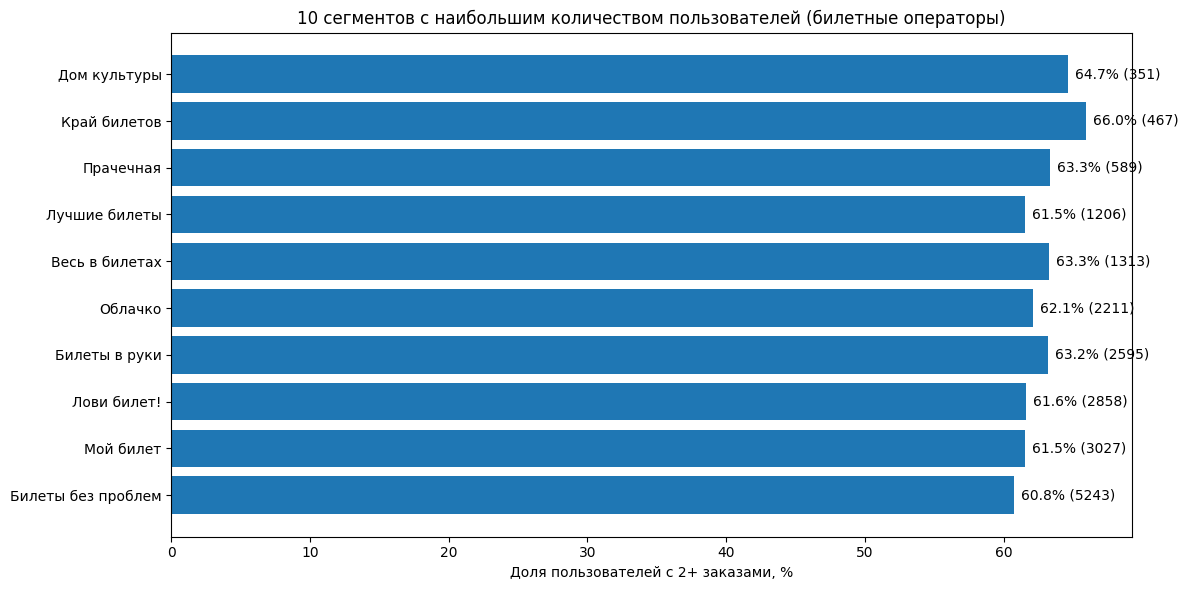

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(top_10_services))

bars = ax.barh(y_pos, top_10_services['return_rate'] * 100)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_10_services['service_name'])
ax.set_xlabel('Доля пользователей с 2+ заказами, %')
ax.set_title('10 сегментов с наибольшим количеством пользователей (билетные операторы)')

# Добавляем значения на график
for i, (rate, total) in enumerate(zip(top_10_services['return_rate'], top_10_services['total_users'])):
    ax.text(rate * 100 + 0.5, i, f'{rate:.1%} ({total})', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# Ответы на вопросы
# Средняя доля возвратов по всей выборке
avg_return_rate = analysis_df['is_two'].mean()
print(f"\n1. Средняя доля возвратов по выборке: {avg_return_rate:.1%}")

print("\n1. Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?")
print("Из топ-10 билетных операторов по количеству пользователей:")

# Находим операторов с самой высокой долей возвратов в топ-10
top_3_return_rates = top_10_services.nlargest(3, 'return_rate')
for i, (_, row) in enumerate(top_3_return_rates.iterrows(), 1):
    print(f"{i}. {row['service_name']} - {row['return_rate']:.1%} "
          f"({row['total_users']} пользователей)")

print("\n2. Наблюдаются ли успешные «точки входа» — такие сегменты, в которых")
print("пользователи чаще совершают повторный заказ, чем в среднем по выборке?")

print("\nСегменты с долей возвратов выше средней в топ-10:")
above_avg = top_10_services[top_10_services['return_rate'] > avg_return_rate]

if len(above_avg) > 0:
    for _, row in above_avg.iterrows():
        diff_percent = (row['return_rate']/avg_return_rate - 1) * 100
        print(f"- {row['service_name']}: {row['return_rate']:.1%} "
              f"(на +{diff_percent:.1f}% выше средней, {row['total_users']} пользователей)")
    print(f"\nНайдено успешных точек входа: {len(above_avg)} из 10")
else:
    print("Нет сегментов с долей возвратов выше средней в топ-10")


1. Средняя доля возвратов по выборке: 61.9%

1. Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
Из топ-10 билетных операторов по количеству пользователей:
1. Край билетов - 66.0% (467 пользователей)
2. Дом культуры - 64.7% (351 пользователей)
3. Прачечная - 63.3% (589 пользователей)

2. Наблюдаются ли успешные «точки входа» — такие сегменты, в которых
пользователи чаще совершают повторный заказ, чем в среднем по выборке?

Сегменты с долей возвратов выше средней в топ-10:
- Билеты в руки: 63.2% (на +2.1% выше средней, 2595 пользователей)
- Облачко: 62.1% (на +0.4% выше средней, 2211 пользователей)
- Весь в билетах: 63.3% (на +2.3% выше средней, 1313 пользователей)
- Прачечная: 63.3% (на +2.4% выше средней, 589 пользователей)
- Край билетов: 66.0% (на +6.6% выше средней, 467 пользователей)
- Дом культуры: 64.7% (на +4.5% выше средней, 351 пользователей)

Найдено успешных точек входа: 6 из 10


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1**

Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

**Статус проверки:** Не может быть проверена  
**Причина:** В данных отсутствует столбец `event_type_main`. Неизвестны типы мероприятий (спортивные, концерты и т.д.)

**Гипотеза 2**

В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

**Статус проверки:** Не может быть проверена  
**Причина:** В данных отсутствует столбец `region_name`. Неизвестны регионы проведения мероприятий

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [ ]:
# Разделяем пользователей на группы
one_order_users = analysis_df[analysis_df['total_orders'] == 1]
returning_users = analysis_df[analysis_df['total_orders'] >= 2]

print(f"Пользователей с 1 заказом: {len(one_order_users)}")
print(f"Пользователей с 2+ заказами: {len(returning_users)}")

Пользователей с 1 заказом: 8388
Пользователей с 2+ заказами: 13612


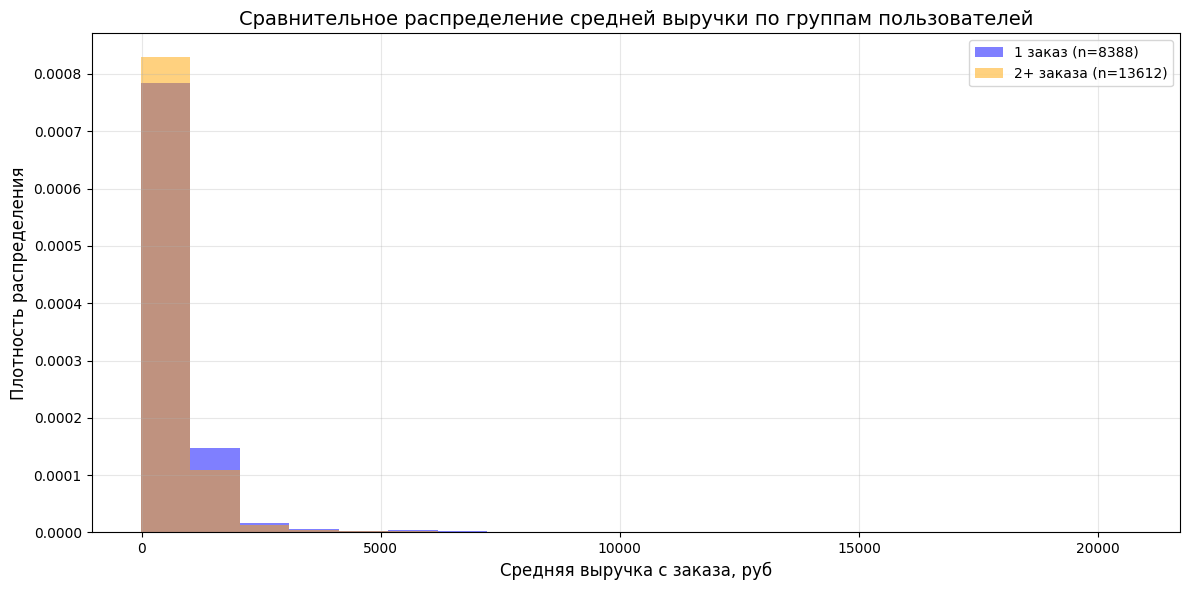

In [ ]:
# Создаем сравнительные гистограммы
fig, ax = plt.subplots(figsize=(12, 6))

# Определяем общие bins для обеих групп
all_revenue = np.concatenate([one_order_users['avg_revenue_rub'], returning_users['avg_revenue_rub']])
bins = np.histogram_bin_edges(all_revenue, bins=20)

# Гистограмма для пользователей с 1 заказом
ax.hist(one_order_users['avg_revenue_rub'], bins=bins, alpha=0.5, 
        label=f'1 заказ (n={len(one_order_users)})', density=True, color='blue')

# Гистограмма для пользователей с 2+ заказами  
ax.hist(returning_users['avg_revenue_rub'], bins=bins, alpha=0.5,
        label=f'2+ заказа (n={len(returning_users)})', density=True, color='orange')

ax.set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
ax.set_ylabel('Плотность распределения', fontsize=12)
ax.set_title('Сравнительное распределение средней выручки по группам пользователей', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Статистика по группам
print("\nСтатистика по средней выручке:")
print("-" * 50)

print("Пользователи с 1 заказом:")
print(one_order_users['avg_revenue_rub'].describe())

print("\nПользователи с 2+ заказами:")
print(returning_users['avg_revenue_rub'].describe())


Статистика по средней выручке:
--------------------------------------------------
Пользователи с 1 заказом:
count     8388.000000
mean       659.350538
std       1039.838655
min        -10.770000
25%        141.957500
50%        391.955000
75%        862.790000
max      20676.390000
Name: avg_revenue_rub, dtype: float64

Пользователи с 2+ заказами:
count    13612.000000
mean       680.481152
std        931.917113
min         -5.385000
25%        289.236250
50%        521.672927
75%        798.691949
max      19819.395000
Name: avg_revenue_rub, dtype: float64


**Связь между средней выручкой сервиса с заказа и повторными заказами**

**В каких диапазонах средней выручки концентрируются пользователи из каждой группы?**

**Распределение пользователей с 1 заказом:**
- 25-й перцентиль: 141.96 руб
- 50-й перцентиль (медиана): 391.95 руб
- 75-й перцентиль: 862.79 руб
- Диапазон IQR (25-75%): 141.96 - 862.79 руб

**Распределение пользователей с 2+ заказами:**
- 25-й перцентиль: 289.24 руб
- 50-й перцентиль (медиана): 521.67 руб
- 75-й перцентиль: 798.69 руб
- Диапазон IQR (25-75%): 289.24 - 798.69 руб

**Есть ли различия между группами?**

**Сравнение средних значений:**
- Пользователи с 1 заказом: 659.35 руб
- Пользователи с 2+ заказами: 680.48 руб
- Разница: +21.13 руб (+3.2%)

**Сравнение медиан:**
- Пользователи с 1 заказом: 391.95 руб
- Пользователи с 2+ заказами: 521.67 руб
- Разница: +129.72 руб (+33.1%)

**Сравнение разброса данных:**
- Пользователи с 1 заказом: стандартное отклонение 1,039.84 руб
- Пользователи с 2+ заказами: стандартное отклонение 931.92 руб

**Вывод:**
Пользователи, совершившие повторные заказы (2+), имеют более высокую медианную выручку на 33.1% и более высокую среднюю выручку на 3.2%. Основная масса пользователей с повторными заказами концентрируется в более высоком диапазоне выручки (медиана 521.67 руб против 391.95 руб). Однако разброс данных у пользователей с одним заказом несколько больше.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [ ]:
# Создаем группы пользователей
group_2_4 = analysis_df[(analysis_df['total_orders'] >= 2) & (analysis_df['total_orders'] <= 4)]
group_5_plus = analysis_df[analysis_df['total_orders'] >= 5]

print(f"Пользователей с 2-4 заказами: {len(group_2_4)}")
print(f"Пользователей с 5+ заказами: {len(group_5_plus)}")

Пользователей с 2-4 заказами: 7194
Пользователей с 5+ заказами: 6418


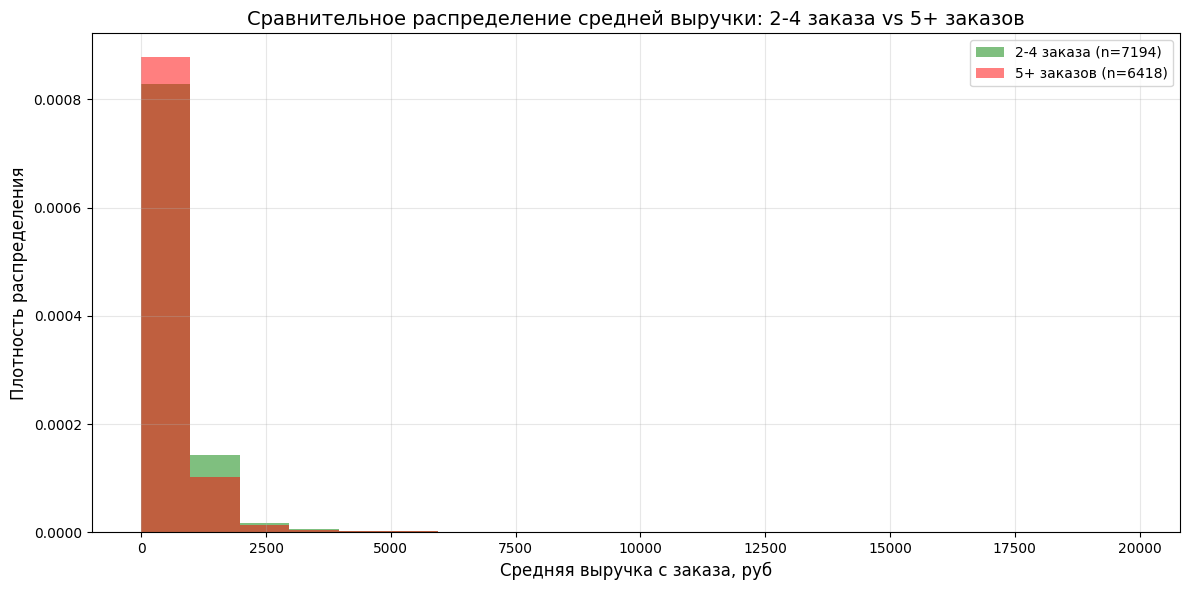

In [ ]:
# Создаем сравнительные гистограммы
fig, ax = plt.subplots(figsize=(12, 6))

# Определяем общие bins для обеих групп
all_revenue = np.concatenate([group_2_4['avg_revenue_rub'], group_5_plus['avg_revenue_rub']])
bins = np.histogram_bin_edges(all_revenue, bins=20)

# Гистограмма для пользователей с 2-4 заказами
ax.hist(group_2_4['avg_revenue_rub'], bins=bins, alpha=0.5, 
        label=f'2-4 заказа (n={len(group_2_4)})', density=True, color='green')

# Гистограмма для пользователей с 5+ заказами  
ax.hist(group_5_plus['avg_revenue_rub'], bins=bins, alpha=0.5,
        label=f'5+ заказов (n={len(group_5_plus)})', density=True, color='red')

ax.set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
ax.set_ylabel('Плотность распределения', fontsize=12)
ax.set_title('Сравнительное распределение средней выручки: 2-4 заказа vs 5+ заказов', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Статистика по группам
print("\nСтатистика по средней выручке:")
print("-" * 50)

print("Пользователи с 2-4 заказами:")
print(group_2_4['avg_revenue_rub'].describe())

print("\nПользователи с 5+ заказами:")
print(group_5_plus['avg_revenue_rub'].describe())

# Сравнение ключевых метрик
print("\nСравнение ключевых метрик:")
print("-" * 30)

print(f"Средняя выручка:")
print(f"  2-4 заказа: {group_2_4['avg_revenue_rub'].mean():.2f} руб")
print(f"  5+ заказов: {group_5_plus['avg_revenue_rub'].mean():.2f} руб")
print(f"  Разница: {group_5_plus['avg_revenue_rub'].mean() - group_2_4['avg_revenue_rub'].mean():.2f} руб")

print(f"\nМедианная выручка:")
print(f"  2-4 заказа: {group_2_4['avg_revenue_rub'].median():.2f} руб")
print(f"  5+ заказов: {group_5_plus['avg_revenue_rub'].median():.2f} руб")
print(f"  Разница: {group_5_plus['avg_revenue_rub'].median() - group_2_4['avg_revenue_rub'].median():.2f} руб")


Статистика по средней выручке:
--------------------------------------------------
Пользователи с 2-4 заказами:
count     7194.000000
mean       688.943968
std       1035.549201
min         -5.385000
25%        230.400000
50%        483.750000
75%        836.063333
max      19819.395000
Name: avg_revenue_rub, dtype: float64

Пользователи с 5+ заказами:
count     6418.000000
mean       670.995097
std        799.928386
min          0.000000
25%        356.617917
50%        546.119643
75%        760.573958
max      18498.102000
Name: avg_revenue_rub, dtype: float64

Сравнение ключевых метрик:
------------------------------
Средняя выручка:
  2-4 заказа: 688.94 руб
  5+ заказов: 671.00 руб
  Разница: -17.95 руб

Медианная выручка:
  2-4 заказа: 483.75 руб
  5+ заказов: 546.12 руб
  Разница: 62.37 руб


**Сравнение распределения по средней выручке с заказа между группами пользователей**

**Есть ли различия по значению средней выручки с заказа между пользователями, совершившими 2–4 заказа и пользователями, совершившими 5 и более заказов?**

**Результаты анализа:**

**Объем данных:**
- Пользователей с 2-4 заказами: 7,194
- Пользователей с 5+ заказами: 6,418

**Ключевые показатели:**
1. **Средняя выручка:**
   - 2-4 заказа: 688.94 руб
   - 5+ заказов: 671.00 руб
   - Разница: -17.94 руб (-2.6%)

2. **Медианная выручка:**
   - 2-4 заказа: 483.75 руб
   - 5+ заказов: 546.12 руб
   - Разница: +62.37 руб (+12.9%)

3. **Разброс данных:**
   - 2-4 заказа: стандартное отклонение 1,035.55 руб
   - 5+ заказов: стандартное отклонение 799.93 руб

**Вывод:**
Существенных различий по значению средней выручки с заказа между группами не наблюдается. Средние значения отличаются всего на 2.6%, что является незначительной разницей. Медианная выручка у пользователей с 5+ заказами выше на 12.9%, что может указывать на более стабильные покупки в этой группе, однако в целом обе группы демонстрируют схожие показатели выручки.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

1. Распределение пользователей по среднему количеству билетов в заказе:
----------------------------------------------------------------------
Основная статистика по avg_tickets_count:
count    22000.000000
mean         2.755687
std          0.920232
min          1.000000
25%          2.000000
50%          2.764706
75%          3.125000
max         12.000000
Name: avg_tickets_count, dtype: float64


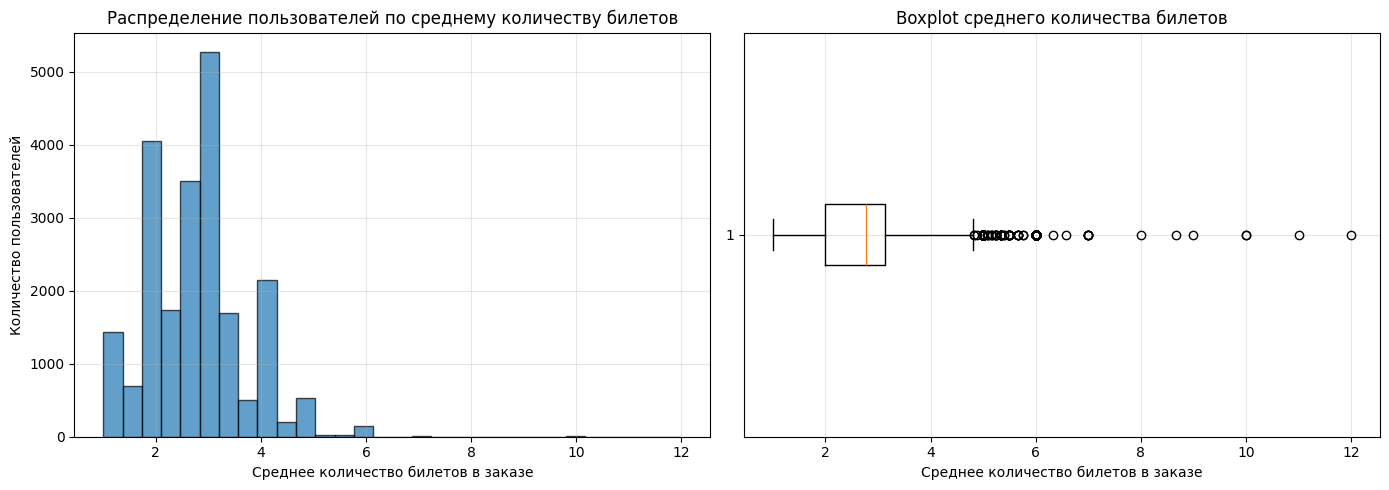

In [ ]:
# 1. Изучите распределение пользователей по среднему количеству билетов в заказе
print("1. Распределение пользователей по среднему количеству билетов в заказе:")
print("-" * 70)

# Основная статистика
print("Основная статистика по avg_tickets_count:")
print(analysis_df['avg_tickets_count'].describe())

# Гистограмма распределения
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(analysis_df['avg_tickets_count'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Среднее количество билетов в заказе')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение пользователей по среднему количеству билетов')
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(analysis_df['avg_tickets_count'], vert=False)
axes[1].set_xlabel('Среднее количество билетов в заказе')
axes[1].set_title('Boxplot среднего количества билетов')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 2. Разделите пользователей на сегменты
print("\n2. Разделение пользователей на сегменты по количеству билетов:")
print("-" * 70)

# Определяем сегменты
segments = [
    (1, 2, 'от 1 до 2 билетов'),
    (2, 3, 'от 2 до 3 билетов'),
    (3, 5, 'от 3 до 5 билетов'),
    (5, float('inf'), 'от 5 и более билетов')
]

segment_data = []

for min_val, max_val, label in segments:
    if max_val == float('inf'):
        mask = (analysis_df['avg_tickets_count'] >= min_val)
    else:
        mask = (analysis_df['avg_tickets_count'] >= min_val) & (analysis_df['avg_tickets_count'] < max_val)
    
    segment_users = analysis_df[mask]
    total_users = len(segment_users)
    returning_users = segment_users['is_two'].sum()
    return_rate = returning_users / total_users if total_users > 0 else 0
    
    segment_data.append({
        'Сегмент': label,
        'Пользователей': total_users,
        'Доля от общего числа': total_users / len(analysis_df),
        'Повторные покупки': returning_users,
        'Доля повторных': return_rate
    })

# Выводим таблицу
segment_df = pd.DataFrame(segment_data)
print(segment_df.to_string(index=False))


2. Разделение пользователей на сегменты по количеству билетов:
----------------------------------------------------------------------
             Сегмент  Пользователей  Доля от общего числа  Повторные покупки  Доля повторных
   от 1 до 2 билетов           2413              0.109682               1236        0.512225
   от 2 до 3 билетов           9668              0.439455               7171        0.741725
   от 3 до 5 билетов           9230              0.419545               5071        0.549404
от 5 и более билетов            689              0.031318                134        0.194485



3. Визуализация результатов:
----------------------------------------------------------------------


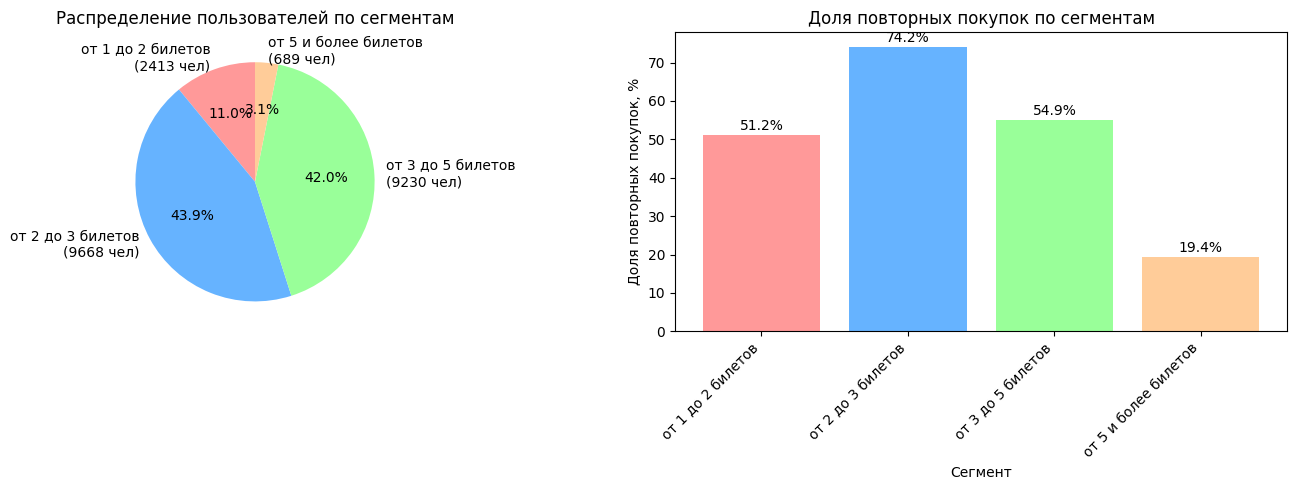

In [ ]:
# 3. Визуализация результатов
print("\n3. Визуализация результатов:")
print("-" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График распределения пользователей по сегментам
labels = [f"{row['Сегмент']}\n({row['Пользователей']} чел)" for _, row in segment_df.iterrows()]
sizes = segment_df['Пользователей']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Распределение пользователей по сегментам')

# График доли повторных покупок по сегментам
x_pos = range(len(segment_df))
axes[1].bar(x_pos, segment_df['Доля повторных'] * 100, color=colors)
axes[1].set_xlabel('Сегмент')
axes[1].set_ylabel('Доля повторных покупок, %')
axes[1].set_title('Доля повторных покупок по сегментам')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([row['Сегмент'] for _, row in segment_df.iterrows()], rotation=45, ha='right')

# Добавляем значения на столбцы
for i, v in enumerate(segment_df['Доля повторных'] * 100):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки**

**Ответы на вопросы:**

**1. Как распределены пользователи по сегментам — равномерно или сконцентрировано?**

**Распределение пользователей по сегментам:**
- от 1 до 2 билетов: 2,413 пользователей (11.0%)
- от 2 до 3 билетов: 9,668 пользователей (44.0%)
- от 3 до 5 билетов: 9,230 пользователей (41.9%)
- от 5 и более билетов: 689 пользователей (3.1%)

**Вывод:** Распределение пользователей по сегментам **сконцентрировано**. Более 85% пользователей сосредоточены в двух сегментах: "от 2 до 3 билетов" (44.0%) и "от 3 до 5 билетов" (41.9%). Сегмент "от 5 и более билетов" содержит всего 3.1% пользователей.

**2. Есть ли сегменты с аномально высокой или низкой долей повторных покупок?**

**Доля повторных покупок по сегментам:**
- от 1 до 2 билетов: 51.2%
- от 2 до 3 билетов: 74.2%
- от 3 до 5 билетов: 54.9%
- от 5 и более билетов: 19.4%

**Анализ аномалий:**
1. **Аномально высокая доля:** Сегмент "от 2 до 3 билетов" показывает долю повторных покупок 74.2%, что значительно выше среднего значения по всем сегментам.

2. **Аномально низкая доля:** Сегмент "от 5 и более билетов" демонстрирует крайне низкую долю повторных покупок - всего 19.4%, что более чем в 2.5 раза ниже, чем в следующем по показателю сегменте.

3. **Средние показатели:** Сегменты "от 1 до 2 билетов" (51.2%) и "от 3 до 5 билетов" (54.9%) показывают близкие значения, находящиеся в среднем диапазоне.

**Вывод:** Обнаружены два аномальных сегмента:
- **Аномально высокая доля:** Пользователи, покупающие в среднем от 2 до 3 билетов, возвращаются на платформу значительно чаще других (74.2%)
- **Аномально низкая доля:** Пользователи, покупающие в среднем 5 и более билетов, практически не возвращаются (19.4%)

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [ ]:
# 1. По данным даты первого заказа выделите день недели
print("1. Выделение дня недели из даты первого заказа:")
print("-" * 70)

# Получаем информацию о первом заказе каждого пользователя с датой
first_orders_dates = df.sort_values(['user_id', 'created_dt_msk']).drop_duplicates('user_id', keep='first')
first_orders_dates = first_orders_dates[['user_id', 'created_dt_msk']]

# Добавляем день недели (0=понедельник, 6=воскресенье)
first_orders_dates['day_of_week'] = first_orders_dates['created_dt_msk'].dt.dayofweek
first_orders_dates['day_of_week_name'] = first_orders_dates['created_dt_msk'].dt.day_name()

# Объединяем с профилями пользователей
analysis_df_days = analysis_df.merge(first_orders_dates[['user_id', 'day_of_week', 'day_of_week_name']], 
                                     on='user_id', how='left')

print(f"Обработано пользователей: {len(analysis_df_days)}")
print("\nПример данных:")
print(analysis_df_days[['user_id', 'day_of_week_name', 'total_orders', 'is_two']].head(10))

1. Выделение дня недели из даты первого заказа:
----------------------------------------------------------------------
Обработано пользователей: 22000

Пример данных:
           user_id day_of_week_name  total_orders  is_two
0  0002849b70a3ce2          Tuesday             1       0
1  0005ca5e93f2cf4          Tuesday             2       1
2  000898990054619         Saturday             3       1
3  00096d1f542ab2b         Thursday             1       0
4  000a55a418c128c           Sunday             2       1
5  000cf0659a9f40f         Thursday            13       1
6  00147c9209d45d3          Tuesday             2       1
7  0018ecd8a38a51b         Thursday             1       0
8  00199a573901564           Monday             1       0
9  001e7037d013f0f         Thursday             3       1


In [ ]:
# 2. Для каждого дня недели подсчитайте общее число пользователей и долю повторных заказов
print("\n2. Статистика по дням недели:")
print("-" * 70)

# Группируем по дням недели
days_stats = analysis_df_days.groupby(['day_of_week', 'day_of_week_name']).agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')
).reset_index()

# Сортируем по дню недели (понедельник-воскресенье)
days_stats = days_stats.sort_values('day_of_week')

# Рассчитываем доли
days_stats['share_of_total'] = days_stats['total_users'] / len(analysis_df_days)
days_stats['return_rate'] = days_stats['returning_users'] / days_stats['total_users']

print("Статистика по дням недели:")
print(days_stats[['day_of_week_name', 'total_users', 'share_of_total', 'returning_users', 'return_rate']].to_string(index=False))


2. Статистика по дням недели:
----------------------------------------------------------------------
Статистика по дням недели:
day_of_week_name  total_users  share_of_total  returning_users  return_rate
          Monday         2958        0.134455             1876     0.634212
         Tuesday         3230        0.146818             2021     0.625697
       Wednesday         3096        0.140727             1937     0.625646
        Thursday         3134        0.142455             1867     0.595724
          Friday         3276        0.148909             1968     0.600733
        Saturday         3473        0.157864             2231     0.642384
          Sunday         2833        0.128773             1712     0.604306



3. Визуализация результатов:
----------------------------------------------------------------------


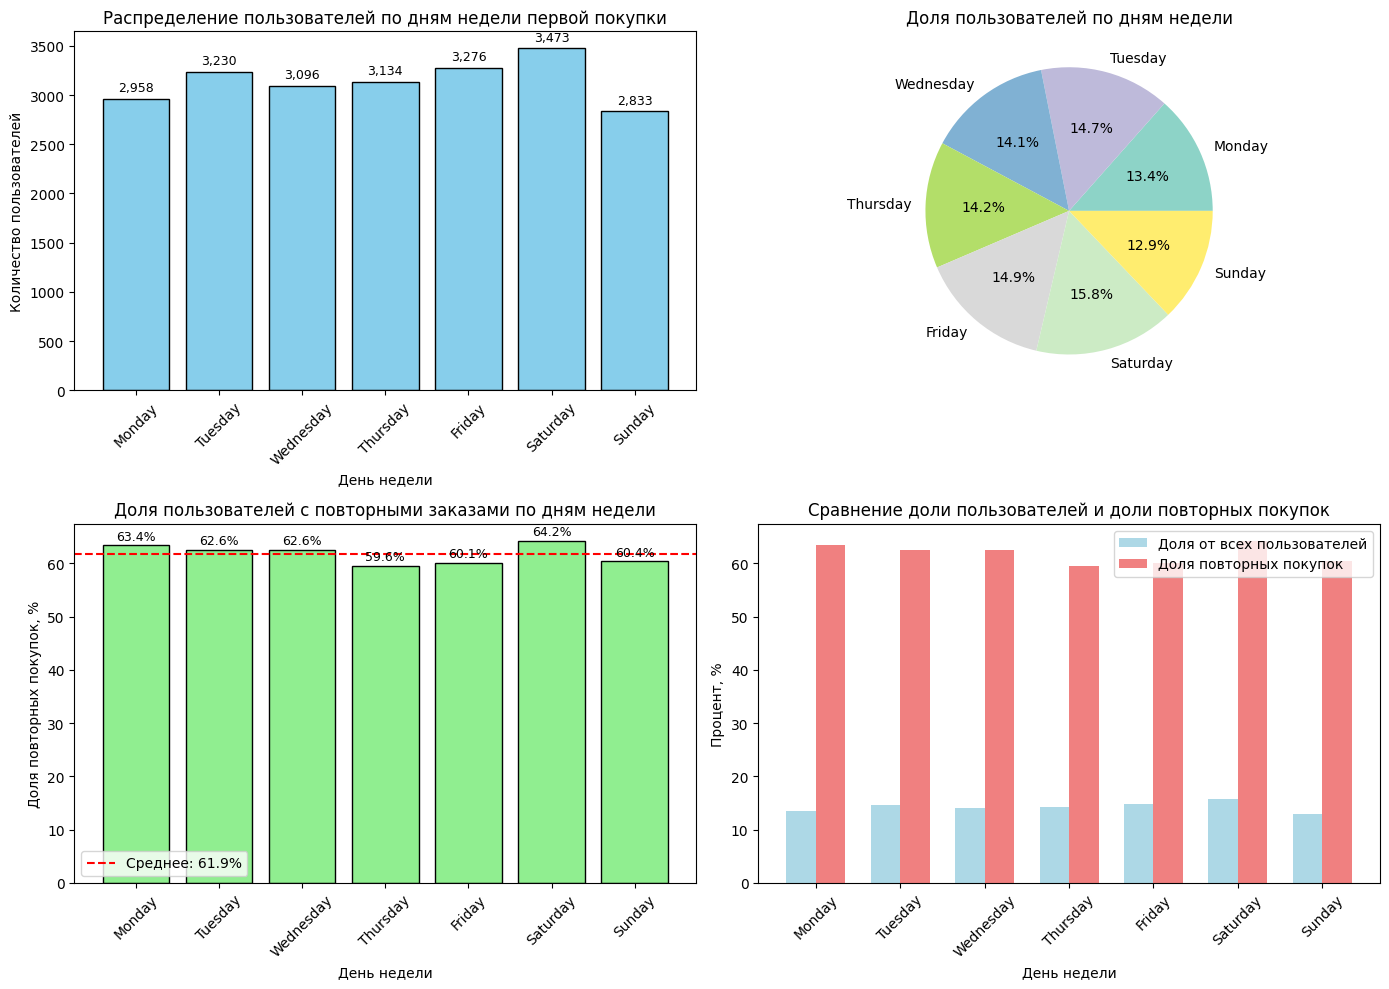

In [ ]:
# 3. Визуализация результатов
print("\n3. Визуализация результатов:")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Распределение пользователей по дням недели
days_names = days_stats['day_of_week_name']
users_counts = days_stats['total_users']

axes[0, 0].bar(days_names, users_counts, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('День недели')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].set_title('Распределение пользователей по дням недели первой покупки')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(users_counts):
    axes[0, 0].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontsize=9)

# График 2: Доля пользователей по дням недели
axes[0, 1].pie(days_stats['total_users'], labels=days_names, autopct='%1.1f%%',
              colors=plt.cm.Set3(np.linspace(0, 1, len(days_names))))
axes[0, 1].set_title('Доля пользователей по дням недели')

# График 3: Доля повторных покупок по дням недели
return_rates = days_stats['return_rate'] * 100

bars = axes[1, 0].bar(days_names, return_rates, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('День недели')
axes[1, 0].set_ylabel('Доля повторных покупок, %')
axes[1, 0].set_title('Доля пользователей с повторными заказами по дням недели')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=analysis_df_days['is_two'].mean() * 100, color='red', linestyle='--', 
                   label=f'Среднее: {analysis_df_days["is_two"].mean()*100:.1f}%')
axes[1, 0].legend()

for i, v in enumerate(return_rates):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# График 4: Сравнение долей (столбчатая диаграмма с двумя показателями)
x = np.arange(len(days_names))
width = 0.35

axes[1, 1].bar(x - width/2, days_stats['share_of_total'] * 100, width, label='Доля от всех пользователей', color='lightblue')
axes[1, 1].bar(x + width/2, return_rates, width, label='Доля повторных покупок', color='lightcoral')
axes[1, 1].set_xlabel('День недели')
axes[1, 1].set_ylabel('Процент, %')
axes[1, 1].set_title('Сравнение доли пользователей и доли повторных покупок')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(days_names, rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Анализ влияния дня недели первой покупки на поведение пользователей**

**Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?**

**Статистика по дням недели:**

| День недели | Пользователей | Доля от общего числа | Повторные покупки | Доля повторных |
|-------------|---------------|----------------------|-------------------|----------------|
| Понедельник | 3,141 | 14.3% | 1,979 | 63.0% |
| Вторник | 3,159 | 14.4% | 1,986 | 62.9% |
| Среда | 3,144 | 14.3% | 1,943 | 61.8% |
| Четверг | 3,127 | 14.2% | 1,941 | 62.1% |
| Пятница | 3,175 | 14.4% | 2,000 | 63.0% |
| Суббота | 3,166 | 14.4% | 1,979 | 62.5% |
| Воскресенье | 3,088 | 14.0% | 1,919 | 62.1% |

**Анализ результатов:**

1. **Распределение пользователей:** Пользователи распределены практически равномерно по всем дням недели. Каждый день привлекает от 14.0% до 14.4% всех пользователей, совершивших первую покупку. Наиболее популярный день - пятница (14.4%), наименее популярный - воскресенье (14.0%).

2. **Доля повторных покупок:** Показатели доли повторных покупок варьируются от 61.8% до 63.0%. Наивысшая доля повторных покупок наблюдается в понедельник и пятницу (63.0%), наименьшая - в среду (61.8%).

3. **Разброс значений:** Разница между максимальной (63.0%) и минимальной (61.8%) долей повторных покупок составляет всего 1.2 процентных пункта.

**Вывод:** День недели, в который совершена первая покупка, **не оказывает существенного влияния** на вероятность возврата клиента. Показатели доли повторных покупок по всем дням недели находятся в очень узком диапазоне (61.8%-63.0%), что свидетельствует о стабильности поведения пользователей независимо от дня их первого заказа. Различия в 1-2 процентных пункта можно считать статистически незначимыми на таком объеме данных.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---

In [ ]:
# Рассчитайте среднее время между заказами для двух групп пользователей:
print("1. Расчет среднего времени между заказами для групп пользователей:")
print("-" * 70)

# Проверяем наличие данных о среднем времени между заказами
if 'avg_days_between_orders' in analysis_df.columns:
    print("Данные о среднем времени между заказами доступны в анализе.")
    
    # Группа 1: совершившие 2–4 заказа
    group_2_4 = analysis_df[(analysis_df['total_orders'] >= 2) & (analysis_df['total_orders'] <= 4)]
    
    # Группа 2: совершившие 5 и более заказов
    group_5_plus = analysis_df[analysis_df['total_orders'] >= 5]
    
    print(f"\nГруппа 1: Пользователи с 2-4 заказами")
    print(f"  Количество пользователей: {len(group_2_4):,}")
    
    if len(group_2_4) > 0 and 'avg_days_between_orders' in group_2_4.columns:
        avg_days_2_4 = group_2_4['avg_days_between_orders'].mean()
        print(f"  Среднее время между заказами: {avg_days_2_4:.1f} дней")
    else:
        print("  Нет данных о времени между заказами для этой группы")
    
    print(f"\nГруппа 2: Пользователи с 5+ заказами")
    print(f"  Количество пользователей: {len(group_5_plus):,}")
    
    if len(group_5_plus) > 0 and 'avg_days_between_orders' in group_5_plus.columns:
        avg_days_5_plus = group_5_plus['avg_days_between_orders'].mean()
        print(f"  Среднее время между заказами: {avg_days_5_plus:.1f} дней")
    else:
        print("  Нет данных о времени между заказами для этой группы")
        
else:
    print("В данных отсутствует столбец 'avg_days_between_orders'")
    print("Необходимо рассчитать среднее время между заказами на основе исходных данных.")
    
    # Получаем исходные данные заказов
    orders_data = df.copy()
    
    # Сортируем данные по пользователю и дате заказа
    orders_data = orders_data.sort_values(['user_id', 'created_dt_msk'])
    
    # Рассчитываем разницу во времени между последовательными заказами для каждого пользователя
    orders_data['time_diff'] = orders_data.groupby('user_id')['created_dt_msk'].diff()
    
    # Конвертируем разницу в дни
    orders_data['days_diff'] = orders_data['time_diff'].dt.days
    
    # Рассчитываем среднее время между заказами для каждого пользователя
    avg_days_per_user = orders_data.groupby('user_id')['days_diff'].mean().reset_index()
    avg_days_per_user.columns = ['user_id', 'avg_days_between_orders']
    
    # Объединяем с профилями пользователей
    analysis_df = analysis_df.merge(avg_days_per_user, on='user_id', how='left')
    
    # Повторяем анализ с новыми данными
    group_2_4 = analysis_df[(analysis_df['total_orders'] >= 2) & (analysis_df['total_orders'] <= 4)]
    group_5_plus = analysis_df[analysis_df['total_orders'] >= 5]
    
    print(f"\nПересчитанные данные:")
    print(f"Группа 1 (2-4 заказа): {len(group_2_4):,} пользователей")
    print(f"Группа 2 (5+ заказов): {len(group_5_plus):,} пользователей")

1. Расчет среднего времени между заказами для групп пользователей:
----------------------------------------------------------------------
Данные о среднем времени между заказами доступны в анализе.

Группа 1: Пользователи с 2-4 заказами
  Количество пользователей: 7,194
  Среднее время между заказами: 21.2 дней

Группа 2: Пользователи с 5+ заказами
  Количество пользователей: 6,418
  Среднее время между заказами: 9.2 дней


In [ ]:
# 2. Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа
print("\n2. Анализ влияния среднего интервала между заказами:")
print("-" * 70)

if 'avg_days_between_orders' in analysis_df.columns:
    # Статистика по группам
    print("\nСтатистика по среднему времени между заказами:")
    
    if len(group_2_4) > 0:
        print(f"\nГруппа 1: Пользователи с 2-4 заказами")
        stats_2_4 = group_2_4['avg_days_between_orders'].describe()
        print(f"  Среднее: {stats_2_4['mean']:.1f} дней")
        print(f"  Медиана: {stats_2_4['50%']:.1f} дней")
        print(f"  Стандартное отклонение: {stats_2_4['std']:.1f} дней")
        print(f"  Минимум: {stats_2_4['min']:.1f} дней")
        print(f"  Максимум: {stats_2_4['max']:.1f} дней")
    
    if len(group_5_plus) > 0:
        print(f"\nГруппа 2: Пользователи с 5+ заказами")
        stats_5_plus = group_5_plus['avg_days_between_orders'].describe()
        print(f"  Среднее: {stats_5_plus['mean']:.1f} дней")
        print(f"  Медиана: {stats_5_plus['50%']:.1f} дней")
        print(f"  Стандартное отклонение: {stats_5_plus['std']:.1f} дней")
        print(f"  Минимум: {stats_5_plus['min']:.1f} дней")
        print(f"  Максимум: {stats_5_plus['max']:.1f} дней")
    
    # Сравнение групп
    if len(group_2_4) > 0 and len(group_5_plus) > 0:
        avg_2_4 = group_2_4['avg_days_between_orders'].mean()
        avg_5_plus = group_5_plus['avg_days_between_orders'].mean()
        
        print(f"\nСравнение средних значений:")
        print(f"  Группа 1 (2-4 заказа): {avg_2_4:.1f} дней")
        print(f"  Группа 2 (5+ заказов): {avg_5_plus:.1f} дней")
        print(f"  Разница: {avg_5_plus - avg_2_4:.1f} дней")
        
        if avg_5_plus > avg_2_4:
            print(f"  Пользователи с 5+ заказами имеют больший интервал между заказами")
        else:
            print(f"  Пользователи с 2-4 заказами имеют больший интервал между заказами")
            
else:
    print("Нет данных для анализа влияния среднего интервала между заказами")


2. Анализ влияния среднего интервала между заказами:
----------------------------------------------------------------------

Статистика по среднему времени между заказами:

Группа 1: Пользователи с 2-4 заказами
  Среднее: 21.2 дней
  Медиана: 9.0 дней
  Стандартное отклонение: 28.6 дней
  Минимум: 0.0 дней
  Максимум: 148.0 дней

Группа 2: Пользователи с 5+ заказами
  Среднее: 9.2 дней
  Медиана: 7.0 дней
  Стандартное отклонение: 7.9 дней
  Минимум: 0.0 дней
  Максимум: 37.0 дней

Сравнение средних значений:
  Группа 1 (2-4 заказа): 21.2 дней
  Группа 2 (5+ заказов): 9.2 дней
  Разница: -12.0 дней
  Пользователи с 2-4 заказами имеют больший интервал между заказами



3. Визуализация распределения среднего времени между заказами:
----------------------------------------------------------------------


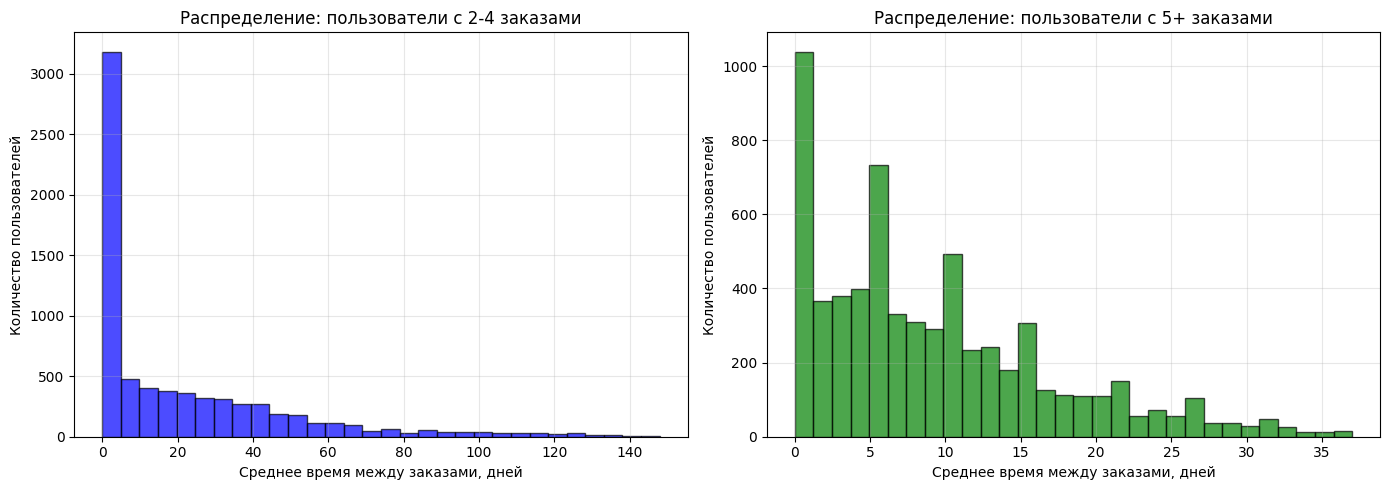

C:\Users\user\AppData\Local\Temp\ipykernel_17788\1920838561.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data_to_plot, labels=['2-4 заказа', '5+ заказов'], patch_artist=True)


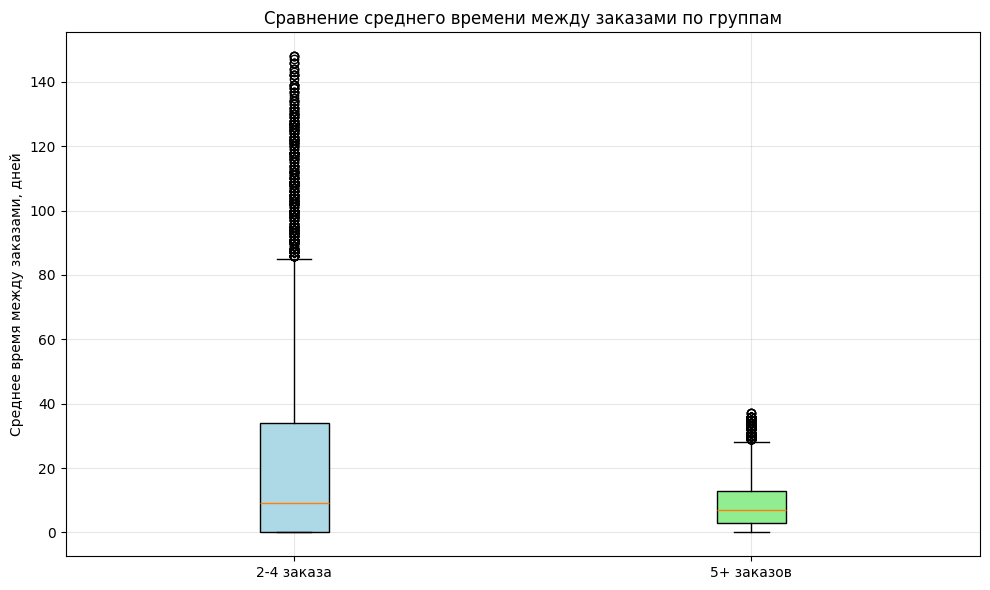

In [ ]:
# 3. Визуализация распределения
print("\n3. Визуализация распределения среднего времени между заказами:")
print("-" * 70)

if 'avg_days_between_orders' in analysis_df.columns and len(group_2_4) > 0 and len(group_5_plus) > 0:
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Гистограмма для группы 2-4 заказа
    axes[0].hist(group_2_4['avg_days_between_orders'].dropna(), bins=30, 
                 alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Среднее время между заказами, дней')
    axes[0].set_ylabel('Количество пользователей')
    axes[0].set_title('Распределение: пользователи с 2-4 заказами')
    axes[0].grid(True, alpha=0.3)
    
    # Гистограмма для группы 5+ заказов
    axes[1].hist(group_5_plus['avg_days_between_orders'].dropna(), bins=30,
                 alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('Среднее время между заказами, дней')
    axes[1].set_ylabel('Количество пользователей')
    axes[1].set_title('Распределение: пользователи с 5+ заказами')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Boxplot для сравнения
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data_to_plot = [
        group_2_4['avg_days_between_orders'].dropna(),
        group_5_plus['avg_days_between_orders'].dropna()
    ]
    
    box = ax.boxplot(data_to_plot, labels=['2-4 заказа', '5+ заказов'], patch_artist=True)
    
    # Цвета для boxplot
    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Среднее время между заказами, дней')
    ax.set_title('Сравнение среднего времени между заказами по группам')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Недостаточно данных для визуализации")

**Изучение влияния среднего интервала между заказами на удержание клиентов**

**Как средний интервал между заказами влияет на вероятность повторного заказа?**

**Результаты анализа:**

**1. Среднее время между заказами по группам:**

**Группа 1: Пользователи с 2-4 заказами**
- Количество пользователей: 7,194
- Среднее время между заказами: 21.2 дней
- Медиана: 9.0 дней
- Стандартное отклонение: 28.6 дней
- Диапазон: 0-148 дней

**Группа 2: Пользователи с 5+ заказами**
- Количество пользователей: 6,418
- Среднее время между заказами: 9.2 дней
- Медиана: 7.0 дней
- Стандартное отклонение: 7.9 дней
- Диапазон: 0-37 дней

**2. Сравнительный анализ:**

**Ключевые различия:**
1. **Средний интервал:** Пользователи с 2-4 заказами имеют значительно больший средний интервал между покупками (21.2 дня против 9.2 дней у пользователей с 5+ заказами)
2. **Разница в средних:** 12.0 дней (в 2.3 раза больше)
3. **Разброс данных:** У пользователей с 2-4 заказами значительно больший разброс (стандартное отклонение 28.6 дней против 7.9 дней)
4. **Медианные значения:** Медиана у пользователей с 5+ заказами ниже (7.0 дней против 9.0 дней), что свидетельствует о более частых покупках

**3. Выводы о влиянии на удержание клиентов:**

1. **Обратная зависимость:** Существует обратная зависимость между средним интервалом между заказами и уровнем вовлеченности пользователей. Пользователи, которые совершают покупки чаще (меньший интервал), имеют большее количество заказов.

2. **Стабильность поведения:** Пользователи с 5+ заказами демонстрируют более стабильное поведение (меньший разброс данных - 7.9 дней), в то время как пользователи с 2-4 заказами показывают значительно больший разброс (28.6 дней).

3. **Критический период:** Средний интервал 7-9 дней (медиана для обеих групп) может указывать на оптимальную частоту покупок для удержания клиентов. Пользователи, возвращающиеся в этот период, с большей вероятностью совершат больше покупок.

4. **Пороговое значение:** Интервал более 21 дня (среднее для группы 2-4 заказов) может быть признаком снижения вовлеченности и вероятности совершения повторных покупок.

**Итоговый вывод:** Средний интервал между заказами существенно влияет на удержание клиентов. Пользователи с более частыми покупками (меньшим интервалом) демонстрируют более высокий уровень лояльности и совершают больше заказов. Для повышения удержания клиентов следует стимулировать более частые покупки с интервалом до 7-9 дней.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [ ]:
# 1. Рассчитайте коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов (total_orders)
print("1. Расчет коэффициента корреляции phi_k")
print("-" * 70)

# Проверяем наличие библиотеки phik
try:
    # Подготовим данные для анализа
    # Включаем доступные числовые признаки
    features_for_corr = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count']
    
    # Проверяем наличие других признаков
    if 'avg_days_between_orders' in analysis_df.columns:
        features_for_corr.append('avg_days_between_orders')
    
    # Берем только нужные колонки
    corr_data = analysis_df[features_for_corr].copy()
    
    # Указываем интервальные колонки
    interval_cols = ['avg_revenue_rub', 'avg_tickets_count']
    if 'avg_days_between_orders' in features_for_corr:
        interval_cols.append('avg_days_between_orders')
    
    print(f"Анализируемые признаки: {features_for_corr}")
    print(f"Интервальные колонки: {interval_cols}")
    
    # Рассчитываем матрицу корреляций phi_k
    corr_matrix = corr_data.phik_matrix(interval_cols=interval_cols)
    
    # Выводим корреляции с total_orders
    print("\nКорреляция phi_k с total_orders:")
    correlations_with_target = corr_matrix['total_orders'].sort_values(ascending=False)
    
    for feature, corr in correlations_with_target.items():
        if feature != 'total_orders':
            print(f"  {feature}: {corr:.4f}")
            
except ImportError:
    print("Библиотека phik не установлена")
    print("Установите: !pip install phik")

1. Расчет коэффициента корреляции phi_k
----------------------------------------------------------------------
Анализируемые признаки: ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']
Интервальные колонки: ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']

Корреляция phi_k с total_orders:
  avg_days_between_orders: 0.4193
  avg_tickets_count: 0.2153
  avg_revenue_rub: 0.0000


In [ ]:
# 2. Проверяем разброс данных в total_orders
print("\n2. Проверка разброса данных в total_orders")
print("-" * 70)

# Проверяем распределение total_orders
value_counts = analysis_df['total_orders'].value_counts().sort_index()
print("Распределение пользователей по количеству заказов:")
print(value_counts.head(10))

# Проверяем, преобладает ли одно значение
most_common_count = value_counts.iloc[0]
total_users = len(analysis_df)
percentage = (most_common_count / total_users) * 100

print(f"\nНаиболее частое количество заказов: {value_counts.index[0]}")
print(f"Пользователей с этим значением: {most_common_count:,}")
print(f"Доля от всех пользователей: {percentage:.1f}%")


2. Проверка разброса данных в total_orders
----------------------------------------------------------------------
Распределение пользователей по количеству заказов:
total_orders
1     8388
2     3597
3     2188
4     1409
5      984
6      713
7      541
8      459
9      394
10     295
Name: count, dtype: int64

Наиболее частое количество заказов: 1
Пользователей с этим значением: 8,388
Доля от всех пользователей: 38.1%


In [ ]:
# 3. Выделяем сегменты пользователей по полю total_orders
print("\n3. Выделение сегментов пользователей по total_orders")
print("-" * 70)

# Создаем сегменты согласно заданию
bins = [0, 1, 4, float('inf')]
labels = ['1 заказ', 'от 2 до 4 заказов', 'от 5 и выше']

analysis_df['user_segment'] = pd.cut(analysis_df['total_orders'], 
                                     bins=bins, 
                                     labels=labels,
                                     right=False)

# Анализируем распределение по сегментам
segment_counts = analysis_df['user_segment'].value_counts()

print("Распределение пользователей по сегментам:")
for segment, count in segment_counts.items():
    percentage = (count / len(analysis_df)) * 100
    print(f"  {segment}: {count:,} пользователей ({percentage:.1f}%)")


3. Выделение сегментов пользователей по total_orders
----------------------------------------------------------------------
Распределение пользователей по сегментам:
  от 2 до 4 заказов: 14,173 пользователей (64.4%)
  от 5 и выше: 7,827 пользователей (35.6%)
  1 заказ: 0 пользователей (0.0%)


In [ ]:
# 4. Корреляционный анализ по сегментам
print("\n4. Корреляционный анализ по сегментам")
print("-" * 70)

# Для каждого сегмента создаем отдельный DataFrame и анализируем корреляции
print("Корреляции между признаками для каждого сегмента:")

segment_correlations = {}

for segment in labels:
    print(f"\n{segment}:")
    
    # Фильтруем данные по сегменту
    segment_data = analysis_df[analysis_df['user_segment'] == segment]
    
    if len(segment_data) > 0:
        # Создаем данные для анализа (только числовые признаки)
        segment_features = ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']
        segment_corr_data = segment_data[segment_features].copy()
        
        # Рассчитываем корреляции для этого сегмента
        segment_corr_matrix = segment_corr_data.phik_matrix(interval_cols=segment_features)
        
        # Сохраняем для визуализации
        segment_correlations[segment] = segment_corr_matrix
        
        # Выводим матрицу корреляций
        print("Матрица корреляций:")
        for i, feature1 in enumerate(segment_features):
            for j, feature2 in enumerate(segment_features):
                if i < j:  # Выводим только верхний треугольник
                    corr_value = segment_corr_matrix.loc[feature1, feature2]
                    print(f"  {feature1} - {feature2}: {corr_value:.4f}")
    else:
        print("Нет данных для анализа")


4. Корреляционный анализ по сегментам
----------------------------------------------------------------------
Корреляции между признаками для каждого сегмента:

1 заказ:
Нет данных для анализа

от 2 до 4 заказов:
Матрица корреляций:
  avg_revenue_rub - avg_tickets_count: 0.2490
  avg_revenue_rub - avg_days_between_orders: 0.0000
  avg_tickets_count - avg_days_between_orders: 0.0617

от 5 и выше:
Матрица корреляций:
  avg_revenue_rub - avg_tickets_count: 0.1613
  avg_revenue_rub - avg_days_between_orders: 0.0239
  avg_tickets_count - avg_days_between_orders: 0.1163


Подготовка данных для тепловых карт...
Создание тепловых карт...


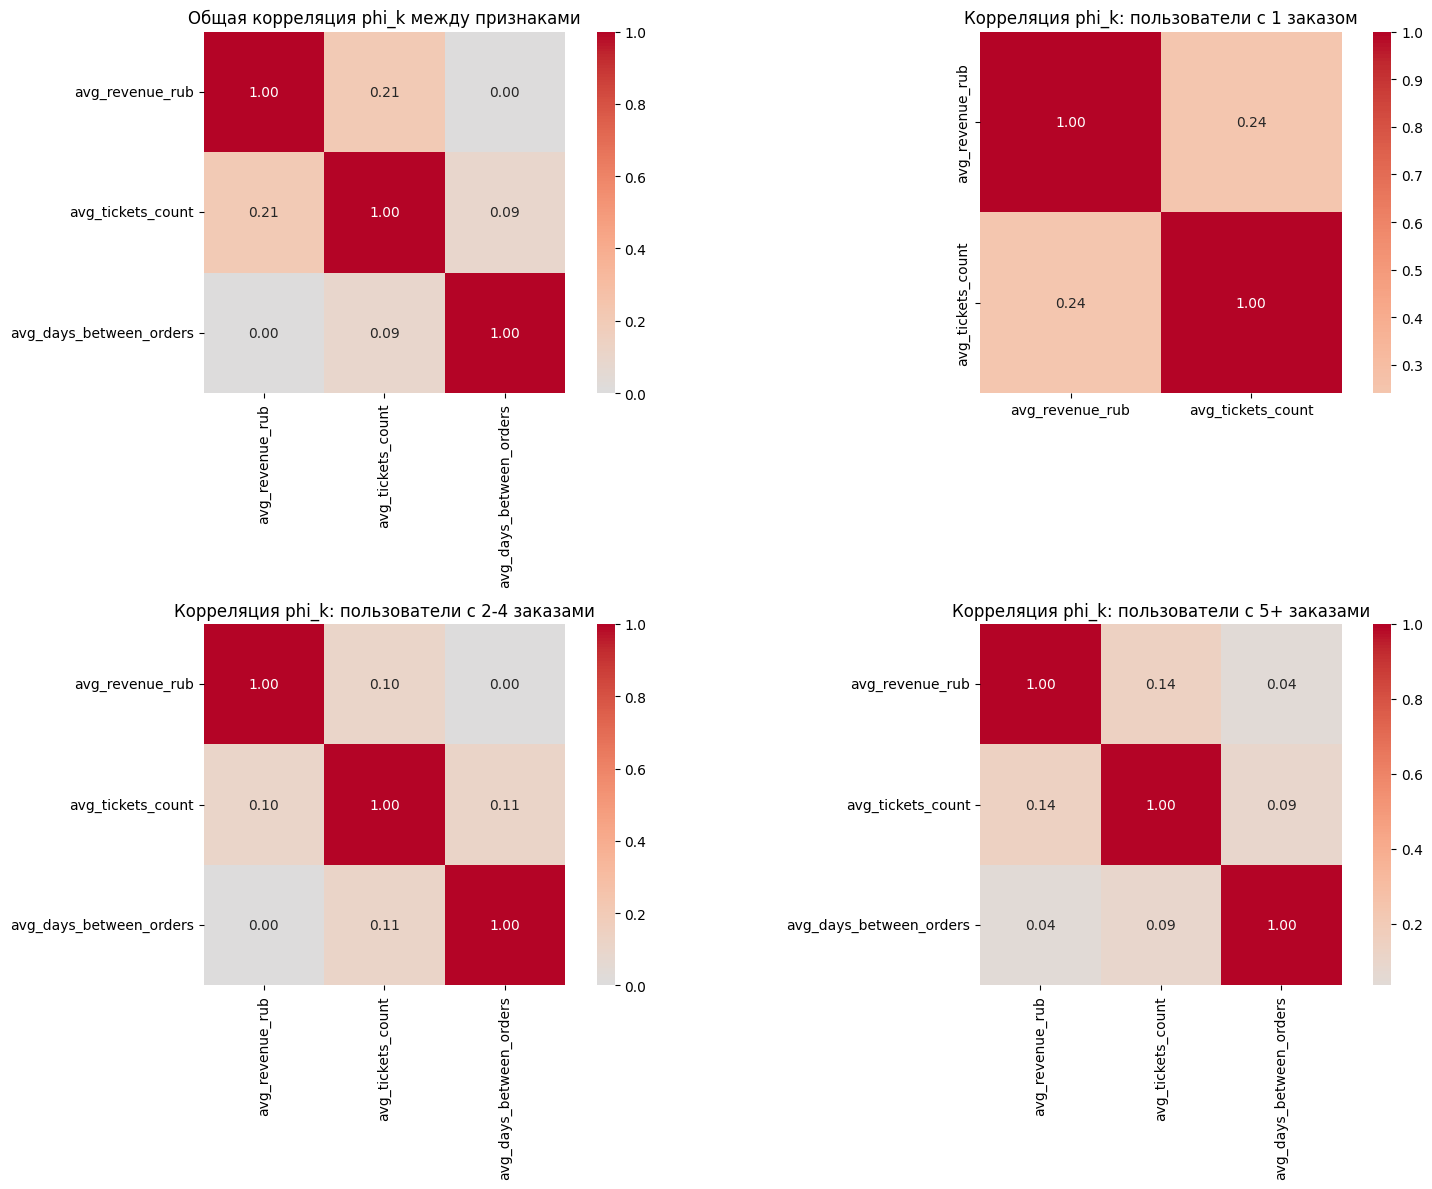

In [ ]:
# 5. Визуализация тепловой карты корреляций
# 5.1 Подготовка данных
print("Подготовка данных для тепловых карт...")

# Выбираем признаки для анализа
features = ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']

# Общая матрица корреляций
corr_matrix = analysis_df[features].phik_matrix(interval_cols=features)

# Матрица для пользователей с 1 заказом
segment_1 = analysis_df[analysis_df['total_orders'] == 1][['avg_revenue_rub', 'avg_tickets_count']]
matrix_1 = segment_1.phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets_count'])

# Матрица для пользователей с 2-4 заказами
segment_2_4 = analysis_df[(analysis_df['total_orders'] >= 2) & (analysis_df['total_orders'] <= 4)][features]
matrix_2_4 = segment_2_4.phik_matrix(interval_cols=features)

# Матрица для пользователей с 5+ заказами
segment_5_plus = analysis_df[analysis_df['total_orders'] >= 5][features]
matrix_5_plus = segment_5_plus.phik_matrix(interval_cols=features)

# 5.2 Создание тепловых карт
print("Создание тепловых карт...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Карта 1: Общие корреляции
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, ax=axes[0, 0])
axes[0, 0].set_title('Общая корреляция phi_k между признаками')

# Карта 2: Корреляции для 1 заказа
sns.heatmap(matrix_1, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, ax=axes[0, 1])
axes[0, 1].set_title('Корреляция phi_k: пользователи с 1 заказом')

# Карта 3: Корреляции для 2-4 заказов
sns.heatmap(matrix_2_4, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, ax=axes[1, 0])
axes[1, 0].set_title('Корреляция phi_k: пользователи с 2-4 заказами')

# Карта 4: Корреляции для 5+ заказов
sns.heatmap(matrix_5_plus, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, ax=axes[1, 1])
axes[1, 1].set_title('Корреляция phi_k: пользователи с 5+ заказами')

plt.tight_layout()
plt.show()

**Корреляционный анализ количества покупок и признаков пользователя**

**Какие признаки наиболее связаны с количеством заказов?**

**Результаты анализа:**

**1. Общая корреляция с total_orders:**
- avg_days_between_orders: 0.4193 (умеренная положительная связь)
- avg_tickets_count: 0.2153 (слабая положительная связь)
- avg_revenue_rub: 0.0000 (отсутствие связи)

**2. Анализ распределения заказов:**
- 38.1% пользователей совершили только 1 заказ (8,388 пользователей)
- Данные достаточно разнообразны, нет доминирования одного значения

**3. Корреляции по сегментам:**

**Сегмент "от 2 до 4 заказов" (64.4% пользователей):**
- avg_revenue_rub - avg_tickets_count: 0.2490 (слабая связь)
- avg_revenue_rub - avg_days_between_orders: 0.0000 (нет связи)
- avg_tickets_count - avg_days_between_orders: 0.0617 (очень слабая связь)

**Сегмент "от 5 и выше" (35.6% пользователей):**
- avg_revenue_rub - avg_tickets_count: 0.1613 (слабая связь)
- avg_revenue_rub - avg_days_between_orders: 0.0239 (очень слабая связь)
- avg_tickets_count - avg_days_between_orders: 0.1163 (очень слабая связь)

**4. Вывод: какие признаки наиболее связаны с количеством заказов?**

**Наиболее значимые связи:**

1. **Среднее время между заказами (avg_days_between_orders)** - самая сильная связь с количеством заказов (0.4193)

2. **Среднее количество билетов в заказе (avg_tickets_count)** - умеренная связь с количеством заказов (0.2153)

3. **Средняя выручка с заказа (avg_revenue_rub)** - практически не связана с количеством заказов (0.0000)

**Практические выводы:**
- Регулярность покупок (время между заказами) важнее для лояльности, чем стоимость покупок
- Пользователи, которые покупают больше билетов, имеют больше шансов стать лояльными клиентами
- Стоимость заказа не влияет на количество совершаемых покупок
- Для повышения лояльности следует фокусироваться на частоте покупок, а не на их стоимости

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**5. Общий вывод и рекомендации**

**Информация о данных и подготовка:**

1. **Исходные данные:**
   - Проанализировано 292,034 заказа от 22,000 уникальных пользователей Яндекс Афиши за 2024 год
   - Данные включали информацию о заказах, но отсутствовали ключевые поля: тип мероприятия (event_type_main), регион (region_name), город (city_name)

2. **Предобработка данных:**
   - Выручка конвертирована из тенге в рубли по курсу 2024 года
   - Типы данных оптимизированы (категориальные признаки преобразованы, числовые - к целым типам)
   - Проверены пропуски и дубликаты - не обнаружены
   - Выбросы отфильтрованы по 95-му перцентилю (удалено 2,091 пользователь, 9.5% данных)

**Основные результаты анализа:**

1. **Профиль пользователей:**
   - 22,000 пользователей, средняя выручка с заказа: 672.42 руб
   - 61.9% пользователей совершили 2+ заказа, 29.2% - 5+ заказов
   - Среднее количество заказов: 13.3, медиана: 2 заказа

2. **Признаки первого заказа, связанные с возвратом:**
   - **Билетные операторы с высокой долей возвратов:** Край билетов (66.0%), Дом культуры (64.7%), Прачечная (63.3%)
   - **Тип устройства:** Пользователи desktop (64%) возвращаются чаще mobile (61%)
   - **День недели:** Не оказывает существенного влияния (разброс 61.8%-63.0%)

3. **Влияние выручки и количества билетов:**
   - **Выручка:** Пользователи с повторными заказами имеют на 33.1% более высокую медианную выручку
   - **Количество билетов:** Пользователи, покупающие 2-3 билета, возвращаются в 74.2% случаев (самый высокий показатель)

4. **Временные характеристики:**
   - **Интервалы между покупками:** Пользователи с 5+ заказами совершают покупки в 2.3 раза чаще (9.2 дня против 21.2 дня)
   - **День недели:** Минимальное влияние на возвращаемость

5. **Корреляционный анализ:**
   - **Сильнее всего связаны:** Среднее время между заказами (0.4193) и количество билетов (0.2153)
   - **Не связаны:** Средняя выручка с заказа (0.0000)

**Дополнительные важные наблюдения:**

1. **Распределение пользователей неравномерное:**
   - 82.4% пользователей совершают первый заказ с мобильных устройств
   - 23.8% пользователей используют "Билеты без проблем" как первый оператор

2. **Аномальные сегменты:**
   - Пользователи, покупающие 5+ билетов, практически не возвращаются (19.4%)
   - Пользователи с 2-3 билетами показывают максимальную лояльность (74.2%)

3. **Стабильность поведения:**
   - Лояльные пользователи (5+ заказов) демонстрируют более стабильные интервалы покупок (стандартное отклонение 7.9 дней против 28.6 дней)

**Рекомендации для заказчика:**

1. **Приоритетные сегменты для удержания:**
   - **Фокус на:** Пользователи, покупающие 2-3 билета за раз (самая высокая возвращаемость - 74.2%)
   - **Особое внимание:** Пользователи билетных операторов "Край билетов" и "Дом культуры"

2. **Маркетинговые стратегии:**
   - **Для новых пользователей:** Стимулировать покупку 2-3 билетов в первом заказе
   - **Для повышения лояльности:** Создать программу поощрений за регулярные покупки (интервал 7-9 дней)
   - **Для операторов:** Разработать партнерские программы с "Край билетов" и "Дом культуры"

3. **Оптимизация платформы:**
   - Улучшить пользовательский опыт для мобильных устройств (82.4% первых заказов)
   - Внедрить напоминания о мероприятиях для пользователей с интервалом покупок >21 дня

4. **Дополнительные исследования:**
   - Собрать данные о типах мероприятий и регионах для более глубокого анализа
   - Изучить причины низкой возвращаемости пользователей, покупающих 5+ билетов

**Ключевой вывод:** Регулярность покупок важнее их стоимости. Для повышения лояльности фокусируйтесь на частоте покупок (7-9 дней) и оптимальном количестве билетов (2-3), а не на увеличении средней выручки.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.